In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
from PIL import Image

In [2]:
def get_kernel(size=(3,3)):
    #assume sigma = 0.707
    #kernel size 3*3
    x,y =np.mgrid[-(math.floor(size[0]/2)):(math.ceil(size[0]/2)),-(math.floor(size[0]/2)):(math.ceil(size[0]/2))]
#     x, y = np.mgrid[-1:2, -1:2]
    kernel = np.exp(-(x**2+y**2))
    #Normalize
    kernel = kernel/kernel.sum()
    return kernel

In [3]:
def padding(img, size=(1, 1)):
    r_pad, c_pad = size
    row, column, ch = img.shape
    img_pad = np.zeros((row + 2 * r_pad, column + 2 * c_pad, ch), dtype=np.uint8)
    img_pad[r_pad:-r_pad, c_pad:-c_pad] = img[:, :]
    for c in range(column+c_pad*2):
        for i in range(c_pad):
            img_pad[i, c] = img_pad[c_pad, c]
            img_pad[c_pad+row+i, c] = img_pad[c_pad+row-1, c]
            
    for r in range(row+r_pad*2):
        for i in range(r_pad):
            img_pad[r, i] = img_pad[r, r_pad]
            img_pad[r, r_pad+column+i] = img_pad[r, r_pad+column-1]
    return img_pad

In [4]:
def zero_padding(img, size=(1,1)):
    r_pad, c_pad = size
    row, column, ch = img.shape
    img_pad = np.zeros((row + 2 * r_pad, column + 2 * c_pad, ch), dtype=np.uint8)
    img_pad[r_pad:-r_pad, c_pad:-c_pad] = img[:, :]
    return img_pad

def Conv2D(img, kernel):
    k_y, k_x = kernel.shape
    p_y = (k_y - 1) // 2
    p_x = (k_x - 1) // 2
    img = padding(img, (p_y, p_x))
    row, column, ch = img.shape
    output_img = np.copy(img)
    for y in range(p_y, row - p_y):
        for x in range(p_x, column - p_x):
            for c in range(ch):
                img_window = img[(y - p_y):(y + p_y) + 1, (x - p_x):(x +p_x) + 1, c]
                output_img[y, x, c] = np.sum(img_window * kernel)   
    
    output_img = output_img[p_y:-p_y, p_x:-p_x]
    return output_img


In [5]:
def subsampling(img, ratio):
    row, column, ch = img.shape
    sub_img = np.zeros((row//ratio, column//ratio, ch), dtype=np.uint8)
    for y in range(sub_img.shape[0]):
        for x in range (sub_img.shape[1]):
            sub_img[y][x] = img[int(y*ratio)][int(x*ratio)]
    return sub_img

In [6]:
def upsampling(img, size):
    row, column, ch = img.shape
    r_up = size[0] // row
    c_up = size[1] // column
    
    up_img = np.zeros(size)
    for y in range(row):
        for x in range(column):
            up_img[y*r_up:(y+1)*r_up+1, x*c_up:(x+1)*c_up+1] = img[y, x]
    return up_img

In [7]:
def image_pyramid(img, kernel, num_layers=5, ratio=2):
    gaussian_pyramid = [img]
    laplacian_pyramid = []
    for i in range(num_layers-1):
        #Gaussian pyramid
        previous_layer = gaussian_pyramid[i]
#         smooth_img = Conv2D(previous_layer, kernel)
        smooth_img = subsampling(previous_layer, ratio)
        gaussian_pyramid.append(smooth_img)
        
        #Laplacian pyramid
        img_high = previous_layer
        img_low = upsampling(smooth_img, img_high.shape)
        laplacian = img_high - img_low
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    
    
        
    return gaussian_pyramid, laplacian_pyramid

In [8]:
def get_magnitude(pyramid):
    magnitudes = [] 
    for i, img in enumerate(pyramid):
        row, column, ch = img.shape
        for c in range(ch):
            sub_img = img[:, :, c]
            dft = np.fft.fft2(sub_img)
            dft_shift = np.fft.fftshift(dft)
            magnitude = np.log(np.abs(dft_shift))
            magnitudes.append(magnitude)
    return magnitudes

In [9]:
def plot_pyramid(pyramid, GRAY, seperate=False, num_layers=5):
    plt.figure(figsize = (20,10))
    for i, img in enumerate(pyramid):
        if GRAY:
            plt.subplot(1, num_layers, i+1), plt.axis('off')
            plt.imshow(img[:, :, 0], cmap='gray')
        else:
            if seperate:
                _, _, ch = img.shape
                for j in range(ch):
                    sub_img = img[:, :, j]
                    plt.subplot(ch, num_layers, num_layers*(j)+i + 1), plt.axis('off'), 
                    
                    plt.imshow(sub_img)
            else:
                plt.subplot(1, num_layers, i+1), plt.axis('off')
                plt.imshow(img)
    plt.show()


In [10]:
def plot_magnitude(magnitudes, num_layers=5):
    plt.figure(figsize = (20,10))
    ch = len(magnitudes) // num_layers
    for i, magnitude in enumerate(magnitudes):
        plt.subplot(ch, num_layers, num_layers*(i%ch)+i//ch + 1), plt.axis('off'), 
        plt.imshow(magnitude.astype('uint8'))
    plt.show()

## main

In [11]:
kernel = get_kernel()
img = cv2.cvtColor(cv2.imread("hw2_data/task1,2_hybrid_pyramid/2_bird.bmp",), cv2.COLOR_RGB2GRAY)
img = img.reshape(img.shape[0],img.shape[1],1)
gaussina_pyramid, laplacian_pyramid = image_pyramid(img, kernel)

## gaussian pyramid

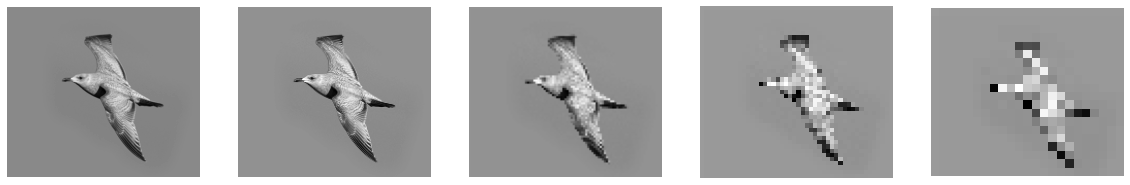

In [12]:
plot_pyramid(gaussina_pyramid, True, seperate=False)

## laplacian pyramid

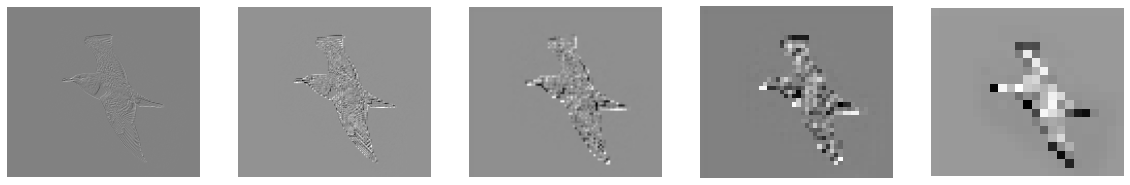

In [13]:
plot_pyramid(laplacian_pyramid, True, seperate=False)

## gaussian pyramid magnitude spectrum

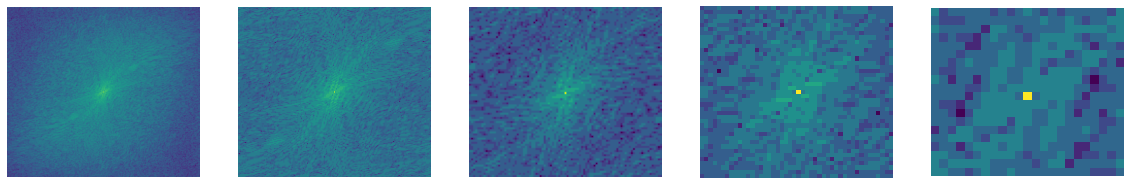

In [14]:
magnitudes = get_magnitude(gaussina_pyramid)
plot_magnitude(magnitudes)

## laplacian pyramid magnitude spectrum

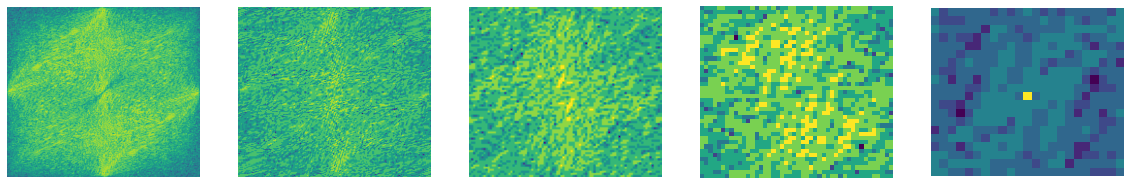

In [15]:
magnitudes = get_magnitude(laplacian_pyramid)
plot_magnitude(magnitudes)